In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import os
import sys
import json
import random
import re
from math import ceil, floor, log, log2, log10, sqrt, exp, factorial, gcd, lcm, pi, e, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2
from collections import Counter, defaultdict, OrderedDict, namedtuple, deque
from functools import partial, partialmethod, reduce, wraps, cache, lru_cache, cached_property, singledispatch, singledispatchmethod
from itertools import count, cycle, product as cartesian_product, permutations, combinations, combinations_with_replacement, accumulate, starmap
from tqdm import tqdm # from tqdm.notebook import tqdm
from uuid import uuid4
from datetime import datetime, timedelta
from time import time, sleep
from toolz import memoize, curry, diff, unique, valmap, valfilter, itemmap, itemfilter, keymap, keyfilter, merge_sorted, interleave, isdistinct, diff, peek, peekn, countby, juxt, excepts, merge, merge_with, assoc, dissoc
from more_itertools import unzip, chunked, chunked_even, minmax, filter_except, numeric_range, make_decorator,replace, locate,countable,unique_everseen, always_iterable,unique_justseen,map_except,count_cycle, mark_ends, sample, distribute, bucket, peekable, seekable,spy,transpose, sieve,polynomial_from_roots,flatten, intersperse, partition, powerset, collapse, split_at, flatten,split_before, split_after, split_when, take

from scipy.sparse import csr_matrix
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import floyd_warshall, dijkstra
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


sys.path.append(os.path.relpath("../../src/"))
from network_v3 import * # my classes and functions

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42

In [3]:
def uniform_sample(n ,long_grid = 100, lat_grid = 100, pop_size=200 , long_spread = 200, lat_spread = 200,seed = SEED):
    npr.seed(seed)
    x = npr.uniform([0,0,pop_size/(long_spread*lat_spread),pop_size/(long_spread*lat_spread)],[long_grid,lat_grid,long_spread,lat_spread],size=(n,4))
    y = npr.randint(0,pop_size ,size=(n,1)).transpose()
    # returns xy-coordinates, population, mean, spread, size
    return np.concatenate((x,y.transpose()),axis=1)

def normal_sample(n,mean = [0,0] , std = [1,1], seed = SEED):
    npr.seed(seed)
    covs = [[std[0],0],[0,std[1]]]
    x = npr.multivariate_normal(mean,covs,size=n)
    #plt.plot(x[:,0],x[:,1],'.')
    return x

def city_sample(n=10 ,long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150, rd=2,seed = SEED,draw=True):
    population_centers = uniform_sample(n=n, long_grid = long_grid, lat_grid = lat_grid, pop_size=pop_size , long_spread = long_spread, lat_spread = lat_spread,seed = seed)
    population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
    population_midpoints = [(i[0],i[1]) for i in population_centers]
    population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
    population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
    population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
    population.append(normal_sample(1000,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
    pop = np.concatenate(population,axis=0)
    pop_rd = np.array(list(map(lambda x: [round(x[0],rd),round(x[1],rd)],pop)))
    if draw:
        plt.plot(pop_rd[:,0], pop_rd[:,1],marker='.',linestyle='None',color='g')
    return pop_rd , population_centers, population_midpoint

def manhattan_distance(x,y):
    return abs(x[0]-y[0]) + abs(x[1]-y[1])

def node_neighbors(node,nodes,radius, distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    neighbors = []
    for i in nodes:
        if distance_function(node,i) < radius:
            neighbors.append(i)
    neighbors.remove(node)
    neighbors.sort(key = lambda x : distance_function(node,x))
    return neighbors

def neighborhood(node,nodes,min=3 ,distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    r = 1
    x = node_neighbors(node,nodes,r,distance_function=distance_function)
    while len(x) < min:
        r+=1
        x = node_neighbors(node,nodes,r)
        if r > 100:
            break
    return x



def road_picker(node, neighborhood):
    npr.seed(int(node.weight*1000))
    edges = [Edge.make(node,i,weight = lambda x: Node.dist(x.node1, x.node2,metric = 'manhattan')) for i in neighborhood]
    picks = min(max(npr.poisson(2),1),len(neighborhood)-1)
    res = [edges[0],edges[1]] + list(npr.choice(edges[2:],size=picks))
    return res



def manhattan_midpoint(x,y):
    return (x[0]+y[0])/2,(x[1]+y[1])/2
def pseudo_edges(city):
    edges2 = []
    for edge in city.edges:
        midpoint = manhattan_midpoint(edge.node1.loc,edge.node2.loc)
        midnode = Node.make(*midpoint,weight = lambda x : x.dist_to(city.population_midpoint_node))
        quarter1 = manhattan_midpoint(edge.node1.loc,midnode.loc)
        quarter1node = Node.make(*quarter1,weight = lambda x : x.dist_to(city.population_midpoint_node))
        quarter3 = manhattan_midpoint(edge.node2.loc,midnode.loc)
        quarter3node = Node.make(*quarter3,weight = lambda x : x.dist_to(city.population_midpoint_node))
        edges2.extend([midnode,quarter1node,quarter3node])
    return edges2

In [4]:
def make_city(seed = SEED):
    pop , population_centers, population_midpoint = city_sample(10,rd=2,seed=seed,draw=False)
    population_midpoint_node = Node.make(*population_midpoint)
    nodes = [Node.make(*i, weight = lambda x : x.dist_to(population_midpoint_node)) for i in pop]
    edges = []
    neighbor_dict = {i:neighborhood(i,nodes,3*(max(i.weight//10,1))) for i in nodes}
    for i in nodes:
        edges += road_picker(i,neighbor_dict[i])
    city = Network(nodes,edges)
    city.midpoint = population_midpoint_node            # midpoint of city
    for i in city.nodes:                                # index attribute for easy access
        i.index = city.nodes.index(i)
    
    city_matrix = np.zeros((len(city.nodes),len(city.nodes)))     # adjacency matrix for dijkstra algorithm
    for i in city.nodes:
        for j in city.adjacent_edges(i):
            k = j.node1 if j.node1 != i else j.node2
            city_matrix[i.index,k.index] = j.weight
            city_matrix[k.index,i.index] = j.weight
    cs = csr_matrix(city_matrix)
    
    city.dij = dijkstra(cs, directed=False)    # dijkstra matrix for shortest path   
    
    
    
    fig , ((ax11,ax13), (ax21,ax23)) = plt.subplots(ncols=2, nrows=2, figsize=(13, 9), sharex=True, sharey=True)
    x = [node.x for node in city.nodes]
    y = [node.y for node in city.nodes]
    pseudo_edge = pseudo_edges(city)
    x_pseudo = [node.x for node in pseudo_edge]
    y_pseudo = [node.y for node in pseudo_edge]
    
    sns.set_style('darkgrid')
    sns.scatterplot(x=x, y=y, ax=ax11, markers='.', alpha=0.7, s= 35)
    sns.kdeplot(x=x, y=y, fill=True, ax=ax13)
    sns.kdeplot(x=x_pseudo, y=y_pseudo, fill=True, ax=ax23)
    
    for edge in city.edges:
        ax21.plot([edge.node1.x,edge.node2.x],[edge.node1.y,edge.node2.y],color = 'b', alpha = 0.3)
    ax11.set_title('City Location Map')
    ax13.set_title('KDE Density')
    ax21.set_title('Road Map')
    ax23.set_title("KDE Density with Roads Represented")
    plt.tight_layout()
    plt.plot()
    return city

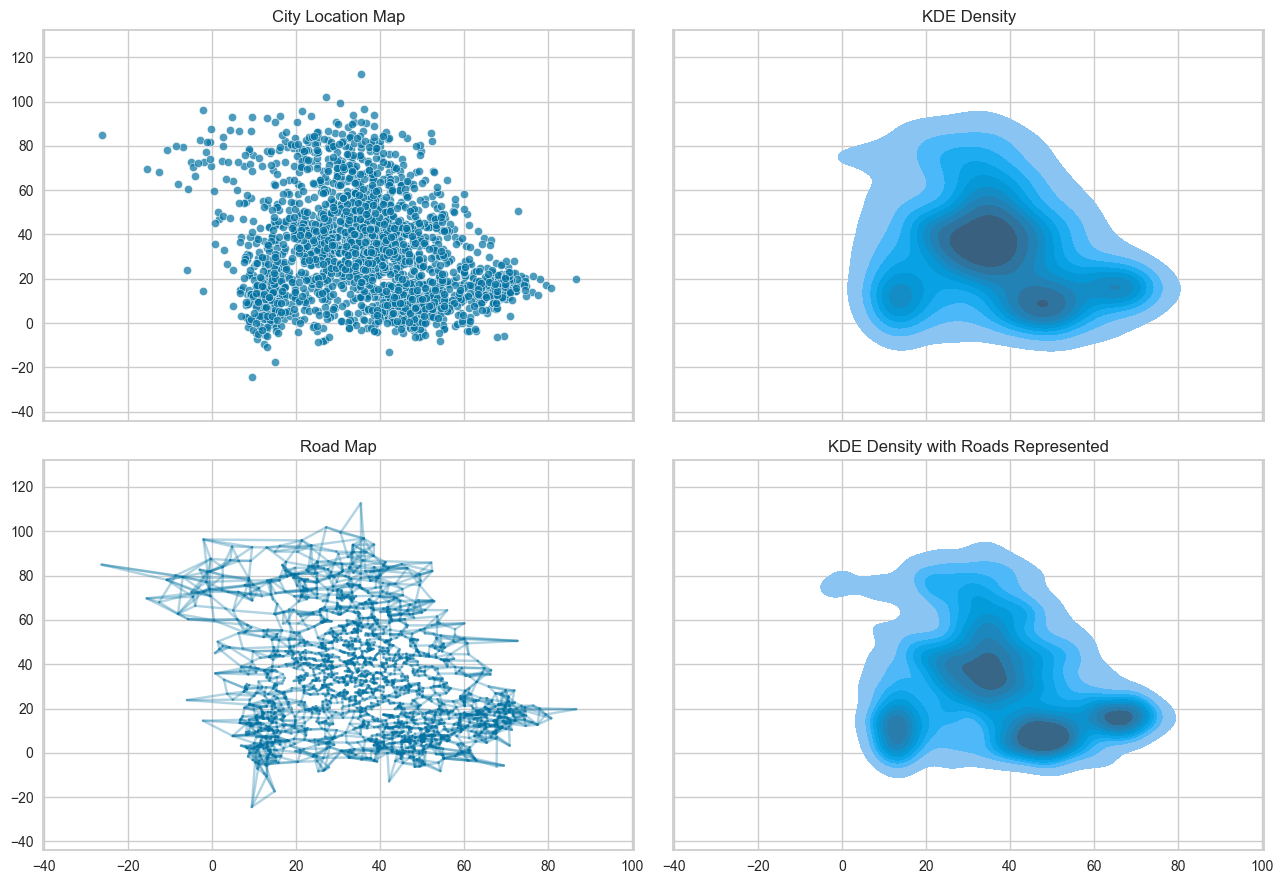

In [5]:
city = make_city(seed = SEED);

In [6]:
### Project ideas:
### Randomly generate population density (eg random points in a square, normal distribution around a point, random means and variances for each point, etc.)
### can we position n distribution centers in a way that minimizes the total distance traveled by the population?
### given distribution centers and budget for m more, can we find the best locations for m more centers?
### analyze the impact of closing centers
### Given a cost of movement and expected profit, can we find if it's worth it to move a center?
### Do this with real data (eg map)
### Cycle analysis (how to choose  best route for a delivery person)
### Traffic flow? (would it be better having a center in the middle of a city or on the outskirts? What if they open in a jagged pattern?)
### Traffic jams? (how to minimize the impact of traffic jams on the delivery person?)
### Can we find the best route for a delivery person that minimizes the total distance traveled and the total time spent in traffic jams?

# Changes - Remove multiedges

In [7]:
def plot_base_city(city):
    plt.scatter([i.x for i in city.nodes], [i.y for i in city.nodes], c = 'b', alpha = 0.2, label = 'Nodes')


def optimal_distributors(city, n = 1, pulls = 5000,draw = True,seed = SEED):
    npr.seed(seed)
    dij_matrix = city.dij
    running_best = [np.inf] + [0]*n
    iterator = npr.choice(city.nodes, size = (pulls,n), replace = True)
    
    for i in tqdm(iterator):
        if len(i) == 1:
            total = dij_matrix[i[0].index].sum()
        else:
            total = sum(map(lambda *x:min(*x),*[dij_matrix[j.index] for j in i]))
        if total > running_best[0]:
            continue
        else:
            running_best = [total] + list(i)
    if draw:
        plt.scatter([i.x for i in running_best[1:]], [i.y for i in running_best[1:]], c = 'r', alpha = 1, label = 'Optimal Distributors')
        plt.legend()
    return running_best[0]/(dij_matrix.shape[0] - n), running_best[1:]

def append_optimal_distributors(city, current,n = 1, pulls = 5000,csr = None,draw = True,seed = SEED):
    npr.seed(seed)
    dij_matrix = city.dij
    running_best = [np.inf] + [0]*n
    iterator = npr.choice(city.nodes, size = (pulls,n), replace = True)
    iterator = np.hstack((iterator, np.hstack((np.atleast_2d(np.repeat(current[i],pulls)).T for i in range(len(current))))))
    
    for i in tqdm(iterator):
        total = sum(map(lambda *x: min(*x),*[dij_matrix[j.index] for j in i]))
        
        if total > running_best[0]:
            continue
        else:
            running_best = [total] + list(i)
    if draw:
        plt.scatter([i.x for i in running_best[1:]], [i.y for i in running_best[1:]], c = 'r', alpha = 1, label = 'Optimal Distributors')
        plt.scatter([i.x for i in current], [i.y for i in current], c = 'g', alpha = 1, label = 'Current Distributors')
        plt.legend()
        plt.plot();
    return running_best[0]/(dij_matrix.shape[0] - n - len(current)), running_best[1:- len(current)]

def elbow_analysis(city):
    xs = [i.x for i in city.nodes]
    ys = [i.y for i in city.nodes]
    data = pd.DataFrame({'x':xs,'y':ys})
    
    modelo = KMeans()
    elbow=KElbowVisualizer(modelo, k=(1, 15))
    elbow.fit(data)
    elbow.show()
    return elbow.elbow_value_

def cluster_analysis(city, clusters = 1, draw = True,seed = SEED):
    xs = [i.x for i in city.nodes]
    ys = [i.y for i in city.nodes]
    data = pd.DataFrame({'x':xs,'y':ys})

    kmeans = KMeans(n_clusters=clusters, random_state=seed).fit(data)
    
    if draw:
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', alpha = 1, label = 'Cluster Centers')
        plt.legend()
        plt.plot();
    return kmeans.cluster_centers_, kmeans.labels_


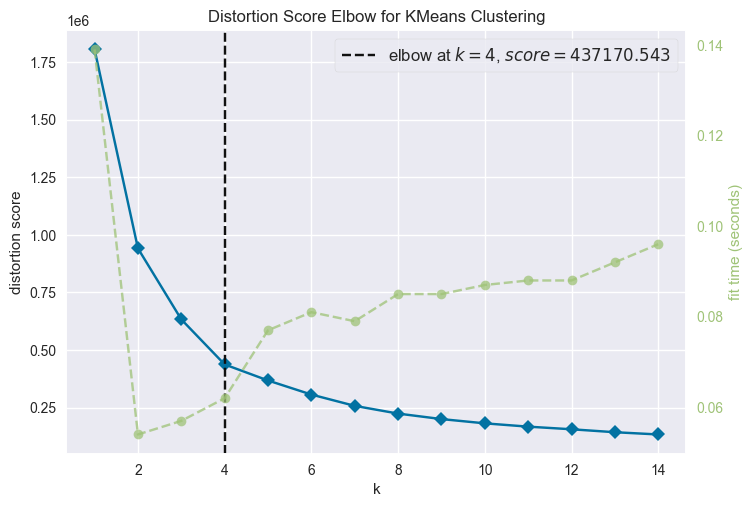

100%|██████████| 5000/5000 [00:04<00:00, 1139.72it/s]


(18.915256880733903,
 [Node: (37.99,67.15)||weight 34.20,
  Node: (34.74,36.44)||weight 0.47,
  Node: (15.34,13.59)||weight 42.01,
  Node: (47.40,9.42)||weight 40.15])

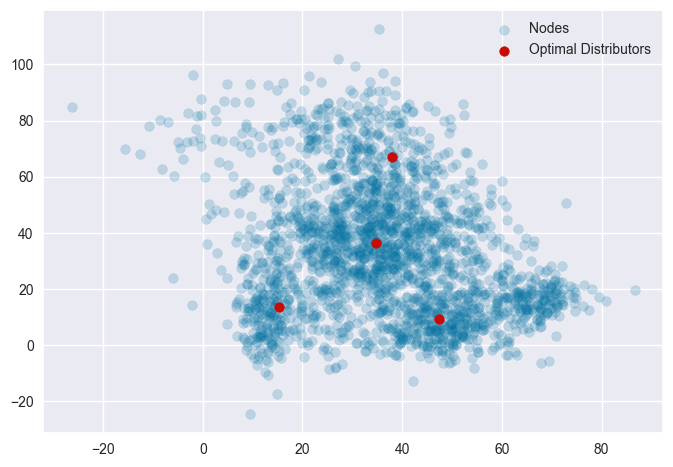

In [8]:
elbow = elbow_analysis(city)
plot_base_city(city)
optimal_distributors(city,elbow,pulls=5000,draw=True)

100%|██████████| 5000/5000 [00:00<00:00, 121921.77it/s]


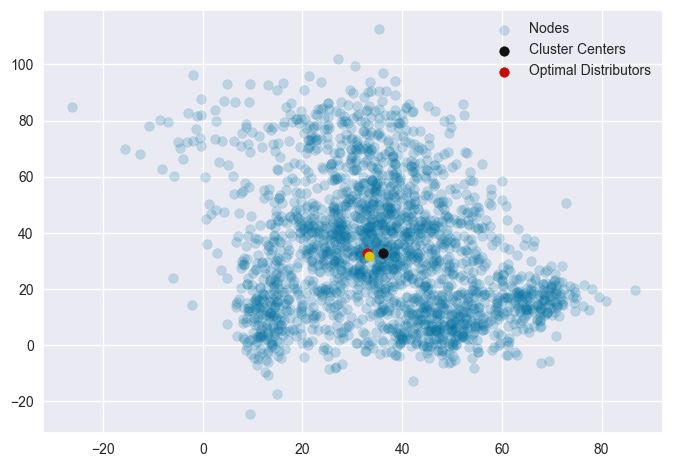

In [9]:
# 1 cluster centre
plot_base_city(city)
cluster_analysis(city, clusters = 1,draw= True)
optimal_distributors(city,1,pulls=5000,draw=True)
avg_dist = sum(city.dij)/(city.dij.shape[0] - 1)
mid = np.where(avg_dist == min(avg_dist))[0][0]
plt.plot(city.nodes[mid].x,city.nodes[mid].y,'y',marker='o', alpha = 1, label = 'Perfect Distributor')

100%|██████████| 5000/5000 [00:07<00:00, 657.22it/s]


(13.967141544117663,
 [Node: (52.38,5.22)||weight 49.33,
  Node: (42.88,59.57)||weight 31.51,
  Node: (10.83,3.03)||weight 57.08,
  Node: (34.34,22.12)||weight 14.48,
  Node: (27.60,37.94)||weight 8.17])

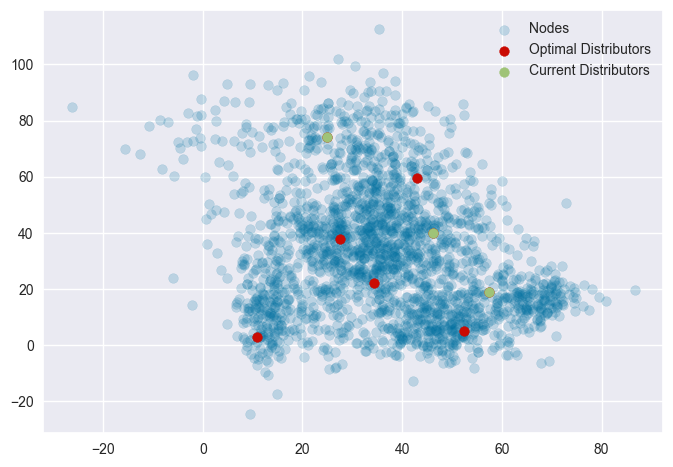

In [10]:
plot_base_city(city)
append_optimal_distributors(city, [city.nodes[400],city.nodes[30],city.nodes[2100]],n=5,pulls=5000,draw=True)

In [144]:
## Give wealth and cost to each node

def uniform_sample(n ,long_grid = 100, lat_grid = 100, pop_size=200 , long_spread = 200, lat_spread = 200,seed = SEED):
    npr.seed(seed)
    x = npr.uniform([0,0,pop_size/(long_spread*lat_spread),pop_size/(long_spread*lat_spread)],[long_grid,lat_grid,long_spread,lat_spread],size=(n,4))
    y = npr.randint(0,pop_size ,size=(n,1)).transpose()
    # returns xy-coordinates, population, mean, spread, size
    return np.concatenate((x,y.transpose()),axis=1)

def normal_sample(n,mean = [0,0] , std = [1,1], seed = SEED):
    npr.seed(seed)
    covs = [[std[0],0],[0,std[1]]]
    x = npr.multivariate_normal(mean,covs,size=n)
    #plt.plot(x[:,0],x[:,1],'.')
    return x


def city_sample_with_wealth(n=10 ,long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150, seed = SEED,rd=2,draw=True):
    population_centers = uniform_sample(n=n, long_grid = long_grid, lat_grid = lat_grid, pop_size=pop_size , long_spread = long_spread, lat_spread = lat_spread,seed = seed)
    population_midpoints = [(i[0],i[1]) for i in population_centers]
    population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
    population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
    
    s = 10
    mid_pop = 1000
    population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
    
    
    
    population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
    population.append(normal_sample(mid_pop,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
    pop = np.concatenate(population,axis=0)

    dist_to_mid = [np.linalg.norm(i-population_midpoint) for i in pop]
    
    def scale(x,n):
        if x<1.5:
            x = 2
        return abs(1/log(x))

    population_wealth = np.concatenate([stats.lognorm.rvs(s,loc=0,scale=scale(i,n),size=1,random_state = SEED) for i in dist_to_mid])
    combined = np.hstack((pop,np.atleast_2d(population_wealth).T))
    pop_rd = np.array(list(map(lambda x: [round(x[0],rd),round(x[1],rd), round(x[2],rd)],combined)))
    if draw:
        df = pd.DataFrame(pop_rd,columns=['x','y','wealth'])
        df.plot(kind='scatter',x='x',y='y',c='wealth',colormap='viridis',alpha=0.5)
    return pop_rd , population_centers, population_midpoint

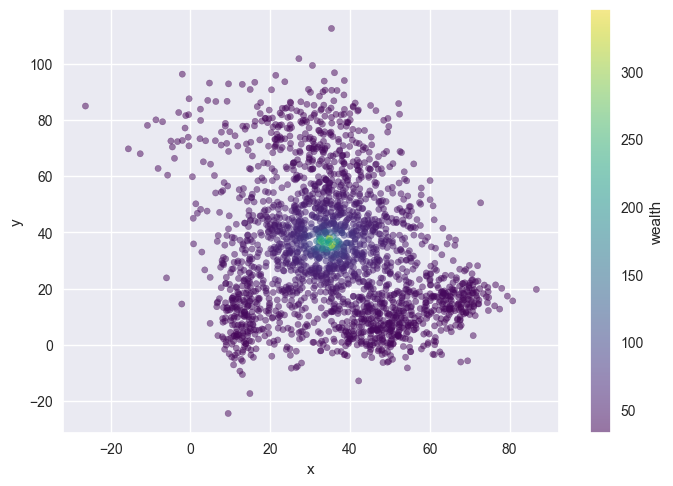

In [145]:
pop, centers,midpoint= city_sample_with_wealth(n=10 ,long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = SEED,rd=2,draw=True)

In [146]:
def make_wealthy_city(seed = SEED):
    pop , population_centers, population_midpoint = city_sample_with_wealth(10,rd=2,seed=seed,draw=False)
    population_midpoint_node = Node.make(*population_midpoint)
    nodes = [Node.make(i,j, weight = k) for i,j,k in pop]
    edges = []
    neighbor_dict = {i:neighborhood(i,nodes,max(i.weight//30,6)) for i in nodes}
    for i in nodes:
        edges += road_picker(i,neighbor_dict[i])
    city = Network(nodes,edges)
    city.midpoint = population_midpoint_node            # midpoint of city
    for i in city.nodes:                                # index attribute for easy access
        i.index = city.nodes.index(i)
    
    city_matrix = np.zeros((len(city.nodes),len(city.nodes)))     # adjacency matrix for dijkstra algorithm
    for i in city.nodes:
        for j in city.adjacent_edges(i):
            k = j.node1 if j.node1 != i else j.node2
            city_matrix[i.index,k.index] = j.weight
            city_matrix[k.index,i.index] = j.weight
    cs = csr_matrix(city_matrix)
    
    city.dij = dijkstra(cs, directed=False)    # dijkstra matrix for shortest path   
    
    
    
    fig , ((ax11,ax13), (ax21,ax23)) = plt.subplots(ncols=2, nrows=2, figsize=(13, 9), sharex=True, sharey=True)
    x = [node.x for node in city.nodes]
    y = [node.y for node in city.nodes]
    pseudo_edge = pseudo_edges(city)
    x_pseudo = [node.x for node in pseudo_edge]
    y_pseudo = [node.y for node in pseudo_edge]
    
    sns.set_style('darkgrid')
    sns.scatterplot(x=x, y=y, ax=ax11, markers='.', alpha=0.7, s= 35)
    sns.kdeplot(x=x, y=y, fill=True, ax=ax13)
    sns.kdeplot(x=x_pseudo, y=y_pseudo, fill=True, ax=ax23)
    
    for edge in city.edges:
        ax21.plot([edge.node1.x,edge.node2.x],[edge.node1.y,edge.node2.y],color = 'b', alpha = 0.3)
    ax11.set_title('City Location Map')
    ax13.set_title('KDE Density')
    ax21.set_title('Road Map')
    ax23.set_title("KDE Density with Roads Represented")
    plt.tight_layout()
    plt.plot()
    return city

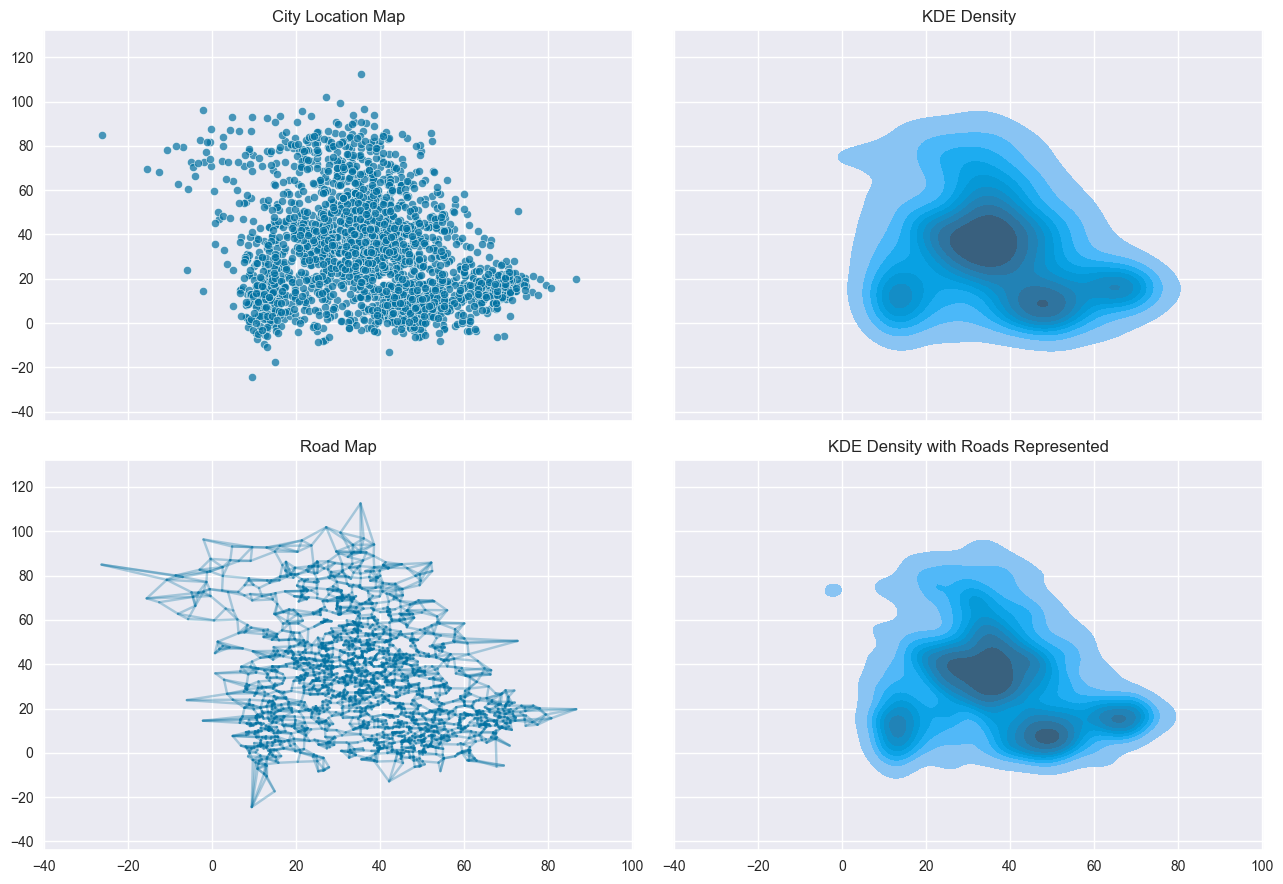

In [147]:
city2 = make_wealthy_city(seed=SEED)

In [19]:
def plot_base_city(city):
    plt.scatter([i.x for i in city.nodes], [i.y for i in city.nodes], c = 'b', alpha = 0.2, label = 'Nodes')


def optimal_distributors(city, n = 1, pulls = 5000,draw = True,seed = SEED):
    npr.seed(seed)
    dij_matrix = city.dij
    running_best = [np.inf] + [0]*n
    iterator = npr.choice(city.nodes, size = (pulls,n), replace = True)
    
    for i in tqdm(iterator):
        if len(i) == 1:
            total = dij_matrix[i[0].index].sum()
        else:
            total = sum(map(lambda *x:min(*x),*[dij_matrix[j.index] for j in i]))
        if total > running_best[0]:
            continue
        else:
            running_best = [total] + list(i)
    if draw:
        plt.scatter([i.x for i in running_best[1:]], [i.y for i in running_best[1:]], c = 'r', alpha = 1, label = 'Optimal Distributors')
        plt.legend()
    return running_best[0]/(dij_matrix.shape[0] - n), running_best[1:]

def append_optimal_distributors(city, current,n = 1, pulls = 5000,csr = None,draw = True,seed = SEED):
    npr.seed(seed)
    dij_matrix = city.dij
    running_best = [np.inf] + [0]*n
    iterator = npr.choice(city.nodes, size = (pulls,n), replace = True)
    iterator = np.hstack((iterator, np.hstack((np.atleast_2d(np.repeat(current[i],pulls)).T for i in range(len(current))))))
    
    for i in tqdm(iterator):
        total = sum(map(lambda *x: min(*x),*[dij_matrix[j.index] for j in i]))
        
        if total > running_best[0]:
            continue
        else:
            running_best = [total] + list(i)
    if draw:
        plt.scatter([i.x for i in running_best[1:]], [i.y for i in running_best[1:]], c = 'r', alpha = 1, label = 'Optimal Distributors')
        plt.scatter([i.x for i in current], [i.y for i in current], c = 'g', alpha = 1, label = 'Current Distributors')
        plt.legend()
        plt.plot();
    return running_best[0]/(dij_matrix.shape[0] - n - len(current)), running_best[1:- len(current)]